# Heart Rate Signals processing (Multi-axis)

From the Kaggle Dataset containing health indicators via smart watches, we process the Heart Rate
Timeseries of all the users simultaneously. Speciffically, we will perform a high-pass filtering
and we will plot the spectrograms (simultaneously) and plot the signals and spectrograms at each
stage.

## Step 1: Initialization

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from caits import visualization, filtering
from caits.fe import spectrogram, istft
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)



In [2]:
def longest_valid_stretch(series):
    """
    Returns the length of the longest stretch of valid values (not NaN) in a series.
    """
    is_valid = series.notna().astype(int)
    return (is_valid.groupby((is_valid != is_valid.shift()).cumsum())
            .transform('size') * is_valid).max()

In [3]:
# Load and parse Heart Rates Dataset
data = pd.read_csv("./data/Fitabase_Data_3.12.16-4.11.16/heartrate_seconds_merged.csv")

reshaped_data = data.pivot(index="Time", columns="Id", values="Value")
reshaped_data.shape

(65272, 3)

In [4]:
reshaped_data.head()


Id,2022484408,2026352035,2347167796
Time,,,
3/29/2016 10:00:00 AM,NaN,NaN,65.0
3/29/2016 10:00:15 AM,NaN,NaN,68.0
3/29/2016 10:00:20 AM,NaN,NaN,71.0
3/29/2016 10:00:25 AM,NaN,NaN,72.0
3/29/2016 10:00:30 AM,NaN,NaN,73.0


In [5]:
def parse_data(reshaped_data):
    longest_stretches = reshaped_data.apply(longest_valid_stretch)

    # Filter columns with stretches above a threshold (e.g., 100 samples)
    threshold = 10
    selected_columns = longest_stretches[longest_stretches >= threshold].index

    # Keep only selected columns and fill NaNs with 0
    filtered_vals = reshaped_data[selected_columns].fillna(0)
    filtered_vals.index = range(len(filtered_vals))

    return filtered_vals

filtered_vals = parse_data(reshaped_data)
filtered_vals.shape


(65272, 3)

In [6]:
filtered_vals.head()


Id,2022484408,2026352035,2347167796
0,0.0,0.0,65.0
1,0.0,0.0,68.0
2,0.0,0.0,71.0
3,0.0,0.0,72.0
4,0.0,0.0,73.0


### Plot the chosen Heart Rate Signals

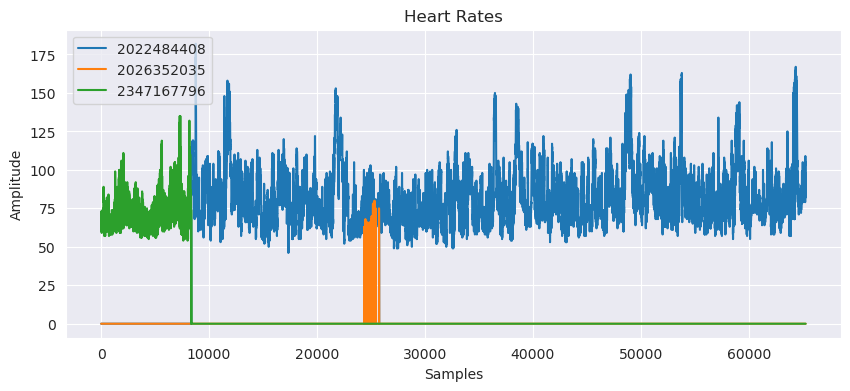

In [7]:
init_fig = visualization.plot_signal(
    filtered_vals.values,
    channels=filtered_vals.columns.tolist(),
    title="Heart Rates"
)

## Step 2: Spectrograms

Calculate the spectrogram for each signal and plot it

In [8]:
spectrograms, sr = spectrogram(
    y=filtered_vals.values,
    n_fft=2048,
    hop_length=512,
    axis=1
)

In [9]:
f = np.fft.rfftfreq(sr, 1 / sr)
x = np.arange(spectrograms[0, :, :].shape[1]) * 512 / sr



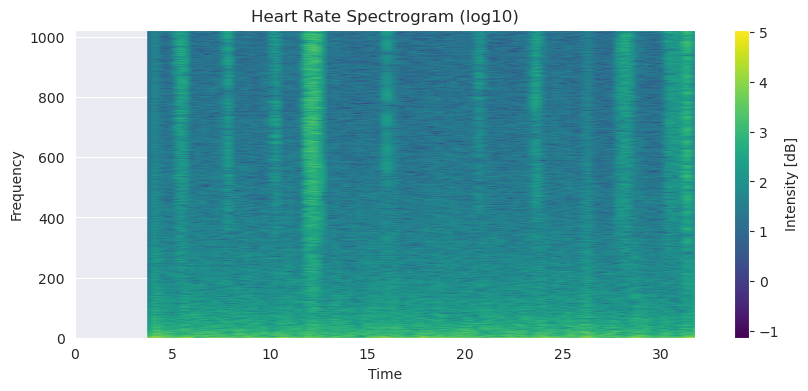

In [10]:
spectrogram_fig = visualization.plot_spectrogram(
    f=f,
    spec=spectrograms[0, :, :],
    x=x,
    log="log10",
    title="Heart Rate Spectrogram (log10)",
    x_axis_name="Time",
)


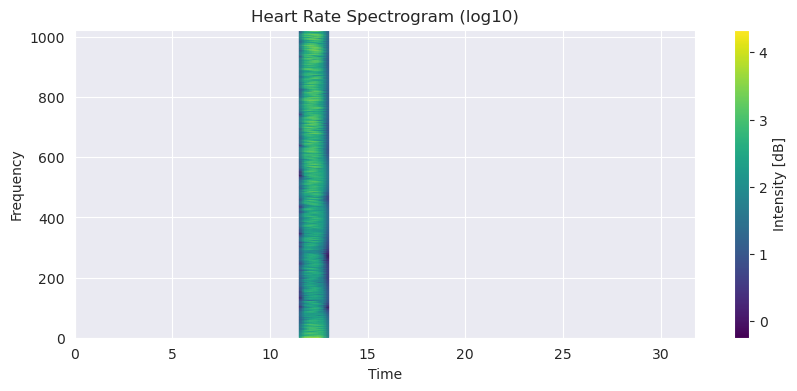

In [11]:
spectrogram_fig = visualization.plot_spectrogram(
    f=f,
    spec=spectrograms[1, :, :],
    x=x,
    log="log10",
    title="Heart Rate Spectrogram (log10)",
    x_axis_name="Time",
)


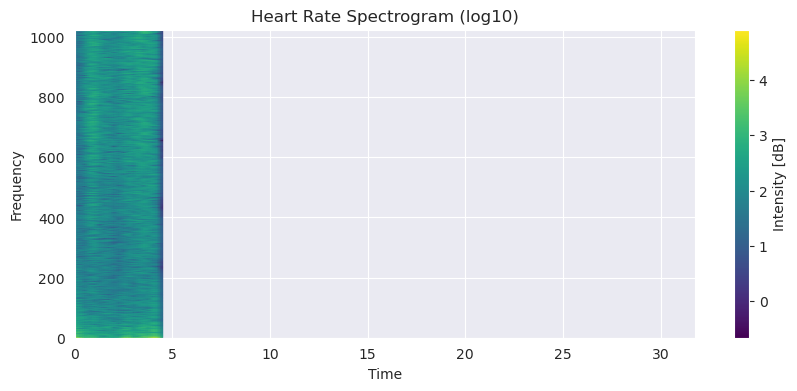

In [12]:
spectrogram_fig = visualization.plot_spectrogram(
    f=f,
    spec=spectrograms[2, :, :],
    x=x,
    log="log10",
    title="Heart Rate Spectrogram (log10)",
    x_axis_name="Time",
)


## Step 3: Filtering

Use a High-Pass filter or the signals, using Butterworth Filter, and plot signal

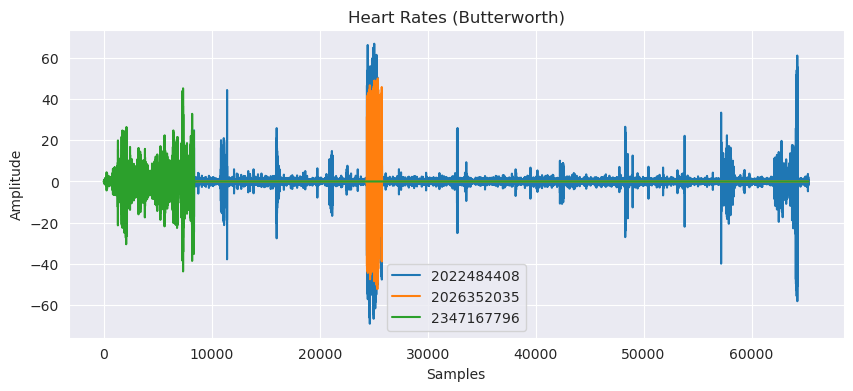

In [13]:
filtered_sigs = filtering.filter_butterworth(
    filtered_vals.values,
    fs=1,
    filter_type="highpass",
    cutoff_freq=0.25)
butterworth_filt = visualization.plot_signal(
    filtered_sigs,
    channels=filtered_vals.columns.tolist(),
    title="Heart Rates (Butterworth)"
)

## Step 4: Spectrograms

For each filtered Heart Rate Signal, calculate and plot the spectrogram

In [14]:
spectrograms_filt, sr_filt = spectrogram(
    y=filtered_sigs.T,
    n_fft=2048,
    hop_length=512
)


In [15]:
f = np.fft.rfftfreq(sr, 1 / sr)
x = np.arange(spectrograms_filt[0, :, :].shape[1]) * 512 / sr




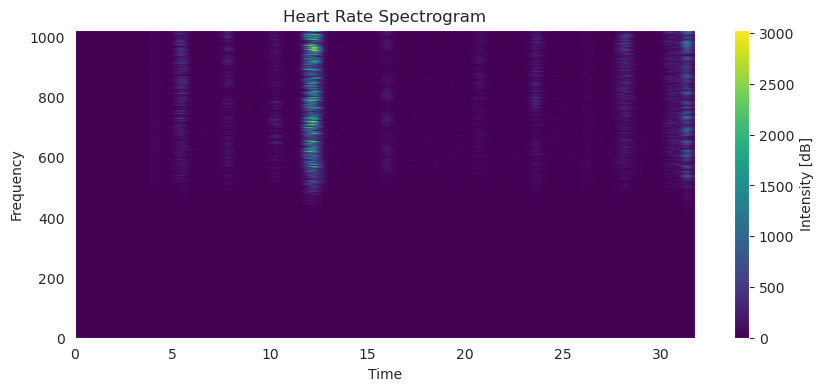

In [16]:
spectrogram_filt_fig = visualization.plot_spectrogram(
    f=f,
    spec=spectrograms_filt[0, :, :],
    x=x,
    title="Heart Rate Spectrogram",
    x_axis_name="Time",
)


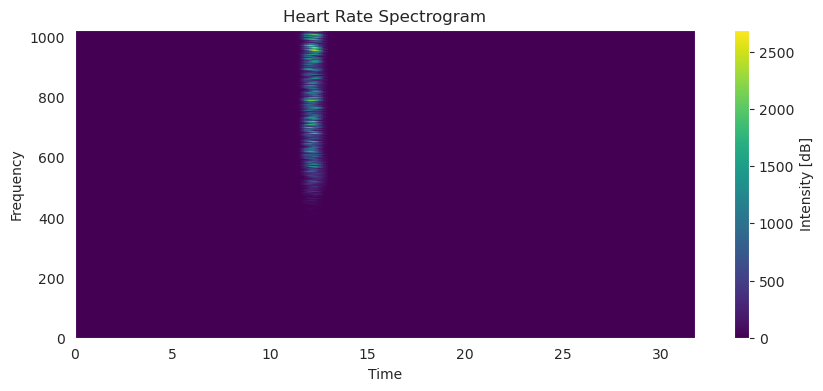

In [17]:
spectrogram_filt_fig = visualization.plot_spectrogram(
    f=f,
    spec=spectrograms_filt[1, :, :],
    x=x,
    title="Heart Rate Spectrogram",
    x_axis_name="Time",
)


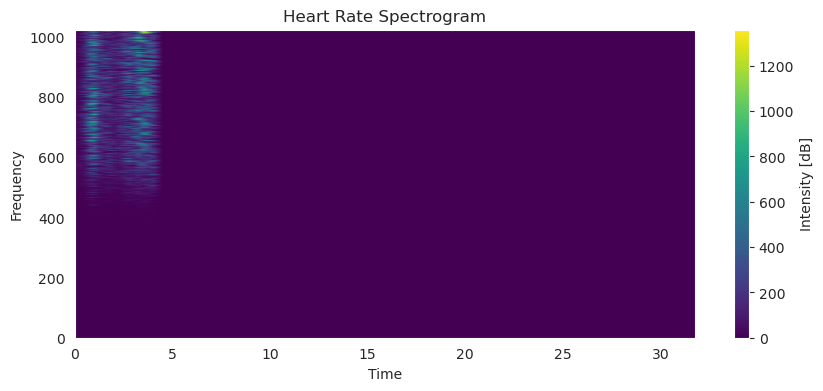

In [18]:
spectrogram_filt_fig = visualization.plot_spectrogram(
    f=f,
    spec=spectrograms_filt[2, :, :],
    x=x,
    title="Heart Rate Spectrogram",
    x_axis_name="Time",
)


## Step 5: Inverse Short-Time Fourier Transform

For each spectrogram, perform Inverse Fourier Transform to get the signals back.

In [19]:
inverse_signals = istft(
    spectrograms_filt,
    n_fft=2048,
    hop_length=512,
    axis=1)
inverse_signals.shape

(65024, 3)

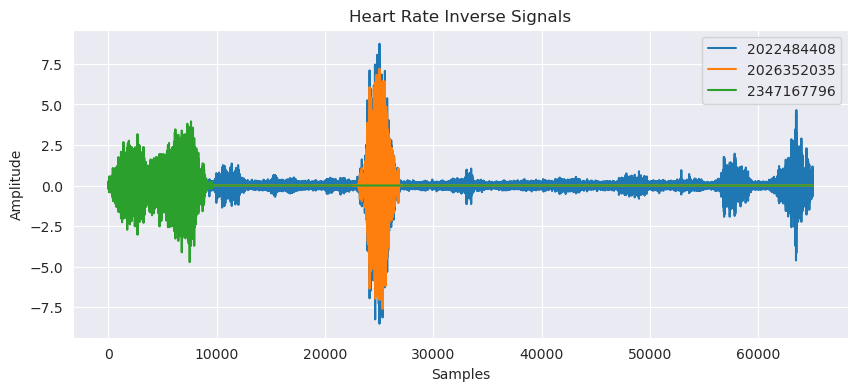

In [20]:
inverse_signals_plot = visualization.plot_signal(
    inverse_signals,
    channels=filtered_vals.columns.tolist(),
    title="Heart Rate Inverse Signals"
)